# **Часть I. Связываем Colab, Drive и Kaggle** (Опционально)

Датасет, с которым я работаю, располагается на [Kaggle](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction). Данный, первый, раздел ноутбука посвящён импортированию этого датасета сюда. Я следую этому [туториалу](https://github.com/bnsreenu/python_for_microscopists/blob/master/Tips_tricks_35_loading_kaggle_data_to_colab.ipynb). Код в следующей ячайке — для того, чтобы не скачивать объёмный файл на компьютер, а сразу импортировать из Kaggle сюда, в Google Colab.

In [ ]:
# ! pip install kaggle

Команда в следующей ячейке позволит Google Colab импортировать (а также редактировать и мн. др.) всё содержимое из моего Google Drive.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Код в следующей ячейке создаст директорий `.kaggle` в настоящем блокноте.


In [ ]:
# ! mkdir ~/.kaggle

Код в следующей ячейке скопирует файл `kaggle.json` в ***общий*** список файлов настоящего блокнота. Я не исполняю этот код, поскольку уже предоставил Google Colab доступ к своему Google Drive, где содержится данный файл.

In [ ]:
# ! cp kaggle.json ~/.kaggle/

Код в следующей ячейке скопирует файл `kaggle.json` в созданный выше директорий `.kaggle`.

In [ ]:
# ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

Код в следующей ячейке ограничит права чтения и записи файлов, оставив их только у меня.

In [ ]:
# ! chmod 600 ~/.kaggle/kaggle.json

Наконец, импортируем желаемый файл из Kaggle!

In [ ]:
# ! kaggle datasets download fedesoriano/company-bankruptcy-prediction

Файл скачался в формате `zip`. Раз`zip`им его!

In [ ]:
# ! unzip company-bankruptcy-prediction.zip

# **Часть II. Анализ датасета**

In [ ]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import sklearn
import xgboost as xgb
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, accuracy_score, recall_score, f1_score
from imblearn.pipeline import Pipeline
#from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from mlxtend.classifier import StackingCVClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score, roc_auc_score
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

В следующей ячейке представим скачанные табличные данные — основной «исходник», с которым предстоит работать, — в формате Padas DataFrame.

In [ ]:
df = pd.read_csv('BankruptcyDataFrame.csv')
df.sample(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
605,0,0.437430,0.501799,0.489480,0.608772,0.608772,0.998992,0.797240,0.809183,0.303216,0.781429,2.201719e-04,2.780000e+09,0.459910,0.000774,0.000000,0.168177,0.168177,0.168177,0.200529,0.314423,0.023156,0.098608,0.158244,0.022009,0.847931,0.688989,0.688989,0.217546,5.390000e+08,0.000412,0.262476,0.369491,0.007370,0.003495,0.629020,0.008954,0.146507,0.853493,0.005098,0.377658,0.005366,0.098580,0.157288,0.407816,0.104948,0.000509,0.012429,3.520000e+09,0.000175,0.031452,0.023001,0.394349,0.019073,0.781755,0.321575,0.604458,0.013353,0.003790,0.000465,0.152197,0.336271,0.278274,0.009598,0.988808,0.734468,0.334122,9.030000e+09,0.925514,0.002147,0.047320,2.108710e-04,1.122184e-04,0.593944,1.280000e+09,0.671571,0.377326,0.988808,0.334122,0.111035,0.641248,0.458982,0.543800,0.314256,0.039291,0,0.773017,0.001658,0.623540,0.608771,0.837939,0.281273,0.026517,0.563393,1,0.024917
5717,0,0.547750,0.598670,0.594464,0.610185,0.610379,0.999088,0.797561,0.809448,0.303576,0.781716,1.497493e-04,5.350000e+07,0.463926,0.000000,0.174512,0.190047,0.190047,0.190047,0.240616,0.321674,0.038674,0.118231,0.195225,0.022124,0.848061,0.689483,0.689483,0.217603,7.220000e+09,0.000477,0.264175,0.377324,0.013083,0.010589,0.630612,0.004609,0.099042,0.900958,0.005576,0.369637,0.005685,0.117674,0.193681,0.402189,0.172414,0.000836,0.007566,1.305029e-04

Посмотрим подробную информацию о df.

In [ ]:
#df.info()
list(df)

['Bankrupt?',
 ' ROA(C) before interest and depreciation before interest',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' Operating Gross Margin',
 ' Realized Sales Gross Margin',
 ' Operating Profit Rate',
 ' Pre-tax net Interest Rate',
 ' After-tax net Interest Rate',
 ' Non-industry income and expenditure/revenue',
 ' Continuous interest rate (after tax)',
 ' Operating Expense Rate',
 ' Research and development expense rate',
 ' Cash flow rate',
 ' Interest-bearing debt interest rate',
 ' Tax rate (A)',
 ' Net Value Per Share (B)',
 ' Net Value Per Share (A)',
 ' Net Value Per Share (C)',
 ' Persistent EPS in the Last Four Seasons',
 ' Cash Flow Per Share',
 ' Revenue Per Share (Yuan ¥)',
 ' Operating Profit Per Share (Yuan ¥)',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Realized Sales Gross Profit Growth Rate',
 ' Operating Profit Growth Rate',
 ' After-tax Net Profit Growth Rate',
 ' Regular Net Profit Growth Rate',
 ' C

In [ ]:
new_columns = ["Банкрот", "ROA[3] (по EBITDA)", "ROA[1] (по EBI)",
              "ROA[2] (по EBIDA)", "Операционная прибыль", "Прибыль от продаж",
              "Коэффициент операционной прибыли",
              "Процентная ставка до налогообложения",
              "Процентная ставка после налогообложения",
              "Неоперационные доходы (расходы)",
              "Непрерывная процентная ставка (после налогообложения)",
              "Соотношение операционных расходов и выручки",
              "Соотношение расходов на R&D и валовой прибыли",
              "Коэффициент операционного денежного потока",
              "Соотношение долгосрочных обязательств и собственного капитала",
              "Ставка налога",
              "NAVPS[2]", "NAVPS[1]", "NAVPS[3]",
              "EPS", "Денежный поток на акцию",
              "Валовая прибыль на акцию", "Операционная прибыль на акцию",
              "Чистая прибыль до налогообложения на акцию",
              "Темпы роста прибыли от продаж",
              "Темпы роста операционной прибыли",
              "Темпы роста чистой прибыли после налогообложения",
              "Темп роста чистой прибыль",
              "Непрерывный темп проста чистой прибыли",
              "Темп роста стоимости активов", "Темп роста чистой стоимости",
              "Темп роста доходности активов",
              "Реинвестирование денежных средств",
              "Коэффициент текущей ликвидности",
              "Коэффициент быстрой ликвидности",
              "Соотношение уплаченных процентов и валовой прибыль",
              "Соотношение обязательств и собственного капитала",
              "Соотношение обязательств и активов",
              "Соотношение чистого капитала и активов",
              "Коэффициент годности основных средств",
              "Показатель долговой нагрузки",
              "Соотношение условных обязательств и чистого капитала",
              "Соотношение операционной прибыли и оплаченного капитала",
              "Соотношение чистой прибыли до налогообложения и оплаченного капитала",
              "Соотношение запасов, дебиторской задолженности и чистого капитала",
              "Оборачиваемость активов",
              "Оборачиваемость дебиторской задолженности",
              "Срок погашения дебиторской задолженности",
              "Оборачиваемость запасов", "Фондоотдача",
              "Коэффициент оборачиваемости собственного капитала",
              "Прибыль на человека", "Операционная прибыль на человека",
              "Allocation rate на человека",
              "Соотношение оборотного капитала и активов",
              "Доля наиболее ликвидных активов", "Доля оборотных активов",
              "Доля денежных средств в активах",
#              "Соотношение оборотных активов и текущих обязательств",
              "Соотношение наиболее ликвидных активов и обязательств",
              "Соотношение денежных средств и текущих обязательств",
              "Соотношение текущих обязательств и активов",
              "Соотношение средств от операционной деятельности и обязательств",
              "Соотношение запасов и оборотного капитала",
              "Соотношение запасов и текущих обязательств",
              "Доля текущих обязательств", "Доля оборотного капитала",
              "Соотношение текущих обязательств и общего капитала",
              "Соотношение долгосрочных обязательств и текущих активов",
              "Соотношение нераспределённой прибыли и активов",
              "Соотношение валовой прибыли и себестоимости продаж",
              "Соотношение себестоимости продаж и активов",
              "Коэффициент оборачиваемости оборотных активов",
              "Коэффициент оборачиваемости наиболее ликвидных активов",
              "Коэффициент оборачиваемости оборотного капитала",
              "Коэффициент оборачиваемости денежных средств",
              "Соотношение денежного потока к продажам",
              "Доля основных средств", "Доля краткосрочных обязательств",
              "Соотношение текущих обязательств и акционерного капитала",
              "Соотношение активов и долгосрочных обязательств",
              "Соотношение денежного потока и активов",
              "Соотношение денежного потока и обязательств",
              "Соотношение операционного денежного потока и активов",
              "Соотношение денежного потока и акционерного капитала",
              "Соотношение текущих обязательств и текущих активов",
              "[Обязательства > активы]",
              "Соотношение чистой прибыли и активов", "Доля активов в ВНП",
              "Бескредитный интервал",
              "Соотношение валовой прибыли и выручки от продаж",
              "Соотношение чистой прибыли и акционерного капитала",
              "Соотношение обязательств и акционерного капитала",
              "Эффект финансового рычага", "Коэффициент покрытия процентов",
              "Отрицательная чистая прибыль более двух лет",
              "Соотношение активов и долгосрочных обязетельств"]

df.columns = new_columns
print(len(new_columns))

96


Набор данных, с которым предстоит работать, был неплохо обработан. В частности, в нём отсутствуют пропуски (так называемые NaN values). Таблица содержит 6819 строк и 96 столбцов. Заметим, что все характеристики, описывающие компании нашей выборки, имеют числовую природу — это позволит легко построить описательные статистики каждой из них. Сделаем это в следующей ячейке.

In [ ]:
pd.set_option('display.max_columns', None)
df.describe()

,Банкрот,ROA[3] (по EBITDA),ROA[1] (по EBI),ROA[2] (по EBIDA),Операционная прибыль,Прибыль от продаж,Коэффициент операционной прибыли,Процентная ставка до налогообложения,Процентная ставка после налогообложения,Неоперационные доходы (расходы),Непрерывная процентная ставка (после налогообложения),Соотношение операционных расходов и выручки,Соотношение расходов на R&D и валовой прибыли,Коэффициент операционного денежного потока,Соотношение долгосрочных обязательств и собственного капитала,Ставка налога,NAVPS[2],NAVPS[1],NAVPS[3],EPS,Денежный поток на акцию,Валовая прибыль на акцию,Операционная прибыль на акцию,Чистая прибыль до налогообложения на акцию,Темпы роста прибыли от продаж,Темпы роста операционной прибыли,Темпы роста чистой прибыли после налогообложения,Темп роста чистой прибыль,Непрерывный темп проста чистой прибыли,Темп роста стоимости активов,Темп роста чистой стоимости,Темп роста доходности активов,Реинвестирование денежных средств,Коэффициент текущей ликвидности,Коэффициент быстрой ликвидности,Соотношение уплаченных процентов и валовой прибыль,Соотношение обязательств и собственного капитала,Соотношение обязательств и активов,Соотношение чистого капитала и активов,Коэффициент годности основных средств,Показатель долговой нагрузки,Соотношение условных обязательств и чистого капитала,Соотношение операционной прибыли и оплаченного капитала,Соотношение чистой прибыли до налогообложения и оплаченного капитала,"Соотношение запасов, дебиторской задолженности и чистого капитала",Оборачиваемость активов,Оборачиваемость дебиторской задолженности,Срок погашения дебиторской задолженности,Оборачиваемость запасов,Фондоотдача,Коэффициент оборачиваемости собственного капитала,Прибыль на человека,Операционная прибыль на человека,Allocation rate на человека,Соотношение оборотного капитала и активов,Доля наиболее ликвидных активов,Доля оборотных активов,Доля денежных средств в активах,Соотношение наиболее ликвидных активов и обязательств,Соотношение денежных средств и текущих обязательств,Соотношение текущих обязательств и активов,Соотношение средств от операционной деятельности и обязательств,Соотношение запасов и оборотного капитала,Соотношение запасов и текущих обязательств,Доля текущих обязательств,Доля оборотного капитала,Соотношение текущих обязательств и общего капитала,Соотношение долгосрочных обязательств и текущих активов,Соотношение нераспределённой прибыли и активов,Соотношение валовой прибыли и себестоимости продаж,Соотношение себестоимости продаж и активов,Коэффициент оборачиваемости оборотных активов,Коэффициент оборачиваемости наиболее ликвидных активов,Коэффициент оборачиваемости оборотного капитала,Коэффициент оборачиваемости денежных средств,Соотношение денежного потока к продажам,Доля основных средств,Доля краткосрочных обязательств,Соотношение текущих обязательств и акционерного капитала,Соотношение активов и долгосрочных обязательств,Соотношение денежного потока и активов,Соотношение денежного потока и обязательств,Соотношение операционного денежного потока и активов,Соотношение денежного потока и акционерного капитала,Соотношение текущих обязательств и текущих активов,[Обязательства > активы],Соотношение чистой прибыли и активов,Доля активов в ВНП,Бескредитный интервал,Соотношение валовой прибыли и выручки от продаж,Соотношение чистой прибыли и акционерного капитала,Соотношение обязательств и акционерного капитала,Эффект финансового рычага,Коэффициент покрытия процентов,Отрицательная чистая прибыль более двух лет,Соотношение активов и долгосрочных обязетельств
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
data = scaler.transform(df)

In [ ]:
scaled_df = pd.DataFrame(data, columns=new_columns)
scaled_df.describe()

,Банкрот,ROA[3] (по EBITDA),ROA[1] (по EBI),ROA[2] (по EBIDA),Операционная прибыль,Прибыль от продаж,Коэффициент операционной прибыли,Процентная ставка до налогообложения,Процентная ставка после налогообложения,Неоперационные доходы (расходы),Непрерывная процентная ставка (после налогообложения),Соотношение операционных расходов и выручки,Соотношение расходов на R&D и валовой прибыли,Коэффициент операционного денежного потока,Соотношение долгосрочных обязательств и собственного капитала,Ставка налога,NAVPS[2],NAVPS[1],NAVPS[3],EPS,Денежный поток на акцию,Валовая прибыль на акцию,Операционная прибыль на акцию,Чистая прибыль до налогообложения на акцию,Темпы роста прибыли от продаж,Темпы роста операционной прибыли,Темпы роста чистой прибыли после налогообложения,Темп роста чистой прибыль,Непрерывный темп проста чистой прибыли,Темп роста стоимости активов,Темп роста чистой стоимости,Темп роста доходности активов,Реинвестирование денежных средств,Коэффициент текущей ликвидности,Коэффициент быстрой ликвидности,Соотношение уплаченных процентов и валовой прибыль,Соотношение обязательств и собственного капитала,Соотношение обязательств и активов,Соотношение чистого капитала и активов,Коэффициент годности основных средств,Показатель долговой нагрузки,Соотношение условных обязательств и чистого капитала,Соотношение операционной прибыли и оплаченного капитала,Соотношение чистой прибыли до налогообложения и оплаченного капитала,"Соотношение запасов, дебиторской задолженности и чистого капитала",Оборачиваемость активов,Оборачиваемость дебиторской задолженности,Срок погашения дебиторской задолженности,Оборачиваемость запасов,Фондоотдача,Коэффициент оборачиваемости собственного капитала,Прибыль на человека,Операционная прибыль на человека,Allocation rate на человека,Соотношение оборотного капитала и активов,Доля наиболее ликвидных активов,Доля оборотных активов,Доля денежных средств в активах,Соотношение наиболее ликвидных активов и обязательств,Соотношение денежных средств и текущих обязательств,Соотношение текущих обязательств и активов,Соотношение средств от операционной деятельности и обязательств,Соотношение запасов и оборотного капитала,Соотношение запасов и текущих обязательств,Доля текущих обязательств,Доля оборотного капитала,Соотношение текущих обязательств и общего капитала,Соотношение долгосрочных обязательств и текущих активов,Соотношение нераспределённой прибыли и активов,Соотношение валовой прибыли и себестоимости продаж,Соотношение себестоимости продаж и активов,Коэффициент оборачиваемости оборотных активов,Коэффициент оборачиваемости наиболее ликвидных активов,Коэффициент оборачиваемости оборотного капитала,Коэффициент оборачиваемости денежных средств,Соотношение денежного потока к продажам,Доля основных средств,Доля краткосрочных обязательств,Соотношение текущих обязательств и акционерного капитала,Соотношение активов и долгосрочных обязательств,Соотношение денежного потока и активов,Соотношение денежного потока и обязательств,Соотношение операционного денежного потока и активов,Соотношение денежного потока и акционерного капитала,Соотношение текущих обязательств и текущих активов,[Обязательства > активы],Соотношение чистой прибыли и активов,Доля активов в ВНП,Бескредитный интервал,Соотношение валовой прибыли и выручки от продаж,Соотношение чистой прибыли и акционерного капитала,Соотношение обязательств и акционерного капитала,Эффект финансового рычага,Коэффициент покрытия процентов,Отрицательная чистая прибыль более двух лет,Соотношение активов и долгосрочных обязетельств
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6

Сколько всего в абсолютном и относительном выражении обанкротившихся и состоятельных компаний в рабочем наборе данных?

In [ ]:
print(scaled_df['Банкрот'].value_counts())
print('—' * 45)
print(f"Финансово устойчивые: \t\t {round(df['Банкрот'].value_counts()[0]/len(df) * 100,2)} % of the dataset")
print(f"Финансово неустойчивые: \t {round(df['Банкрот'].value_counts()[1]/len(df) * 100,2)} % of the dataset")

Банкрот
0.0    6599
1.0     220
Name: count, dtype: int64
—————————————————————————————————————————————
Финансово устойчивые: 		 96.77 % of the dataset
Финансово неустойчивые: 	 3.23 % of the dataset


Посмотрим на распределения признаков.

(array([6599.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         220.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

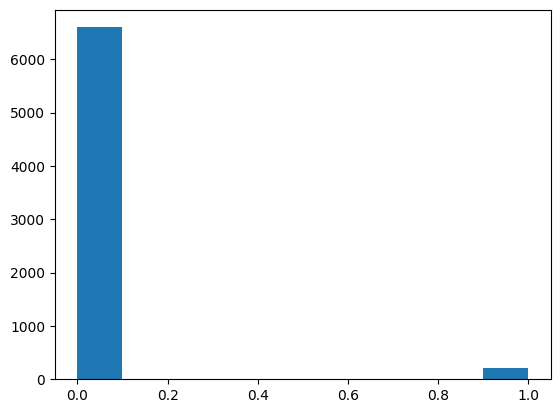

In [ ]:
plt.hist(scaled_df['Банкрот'])

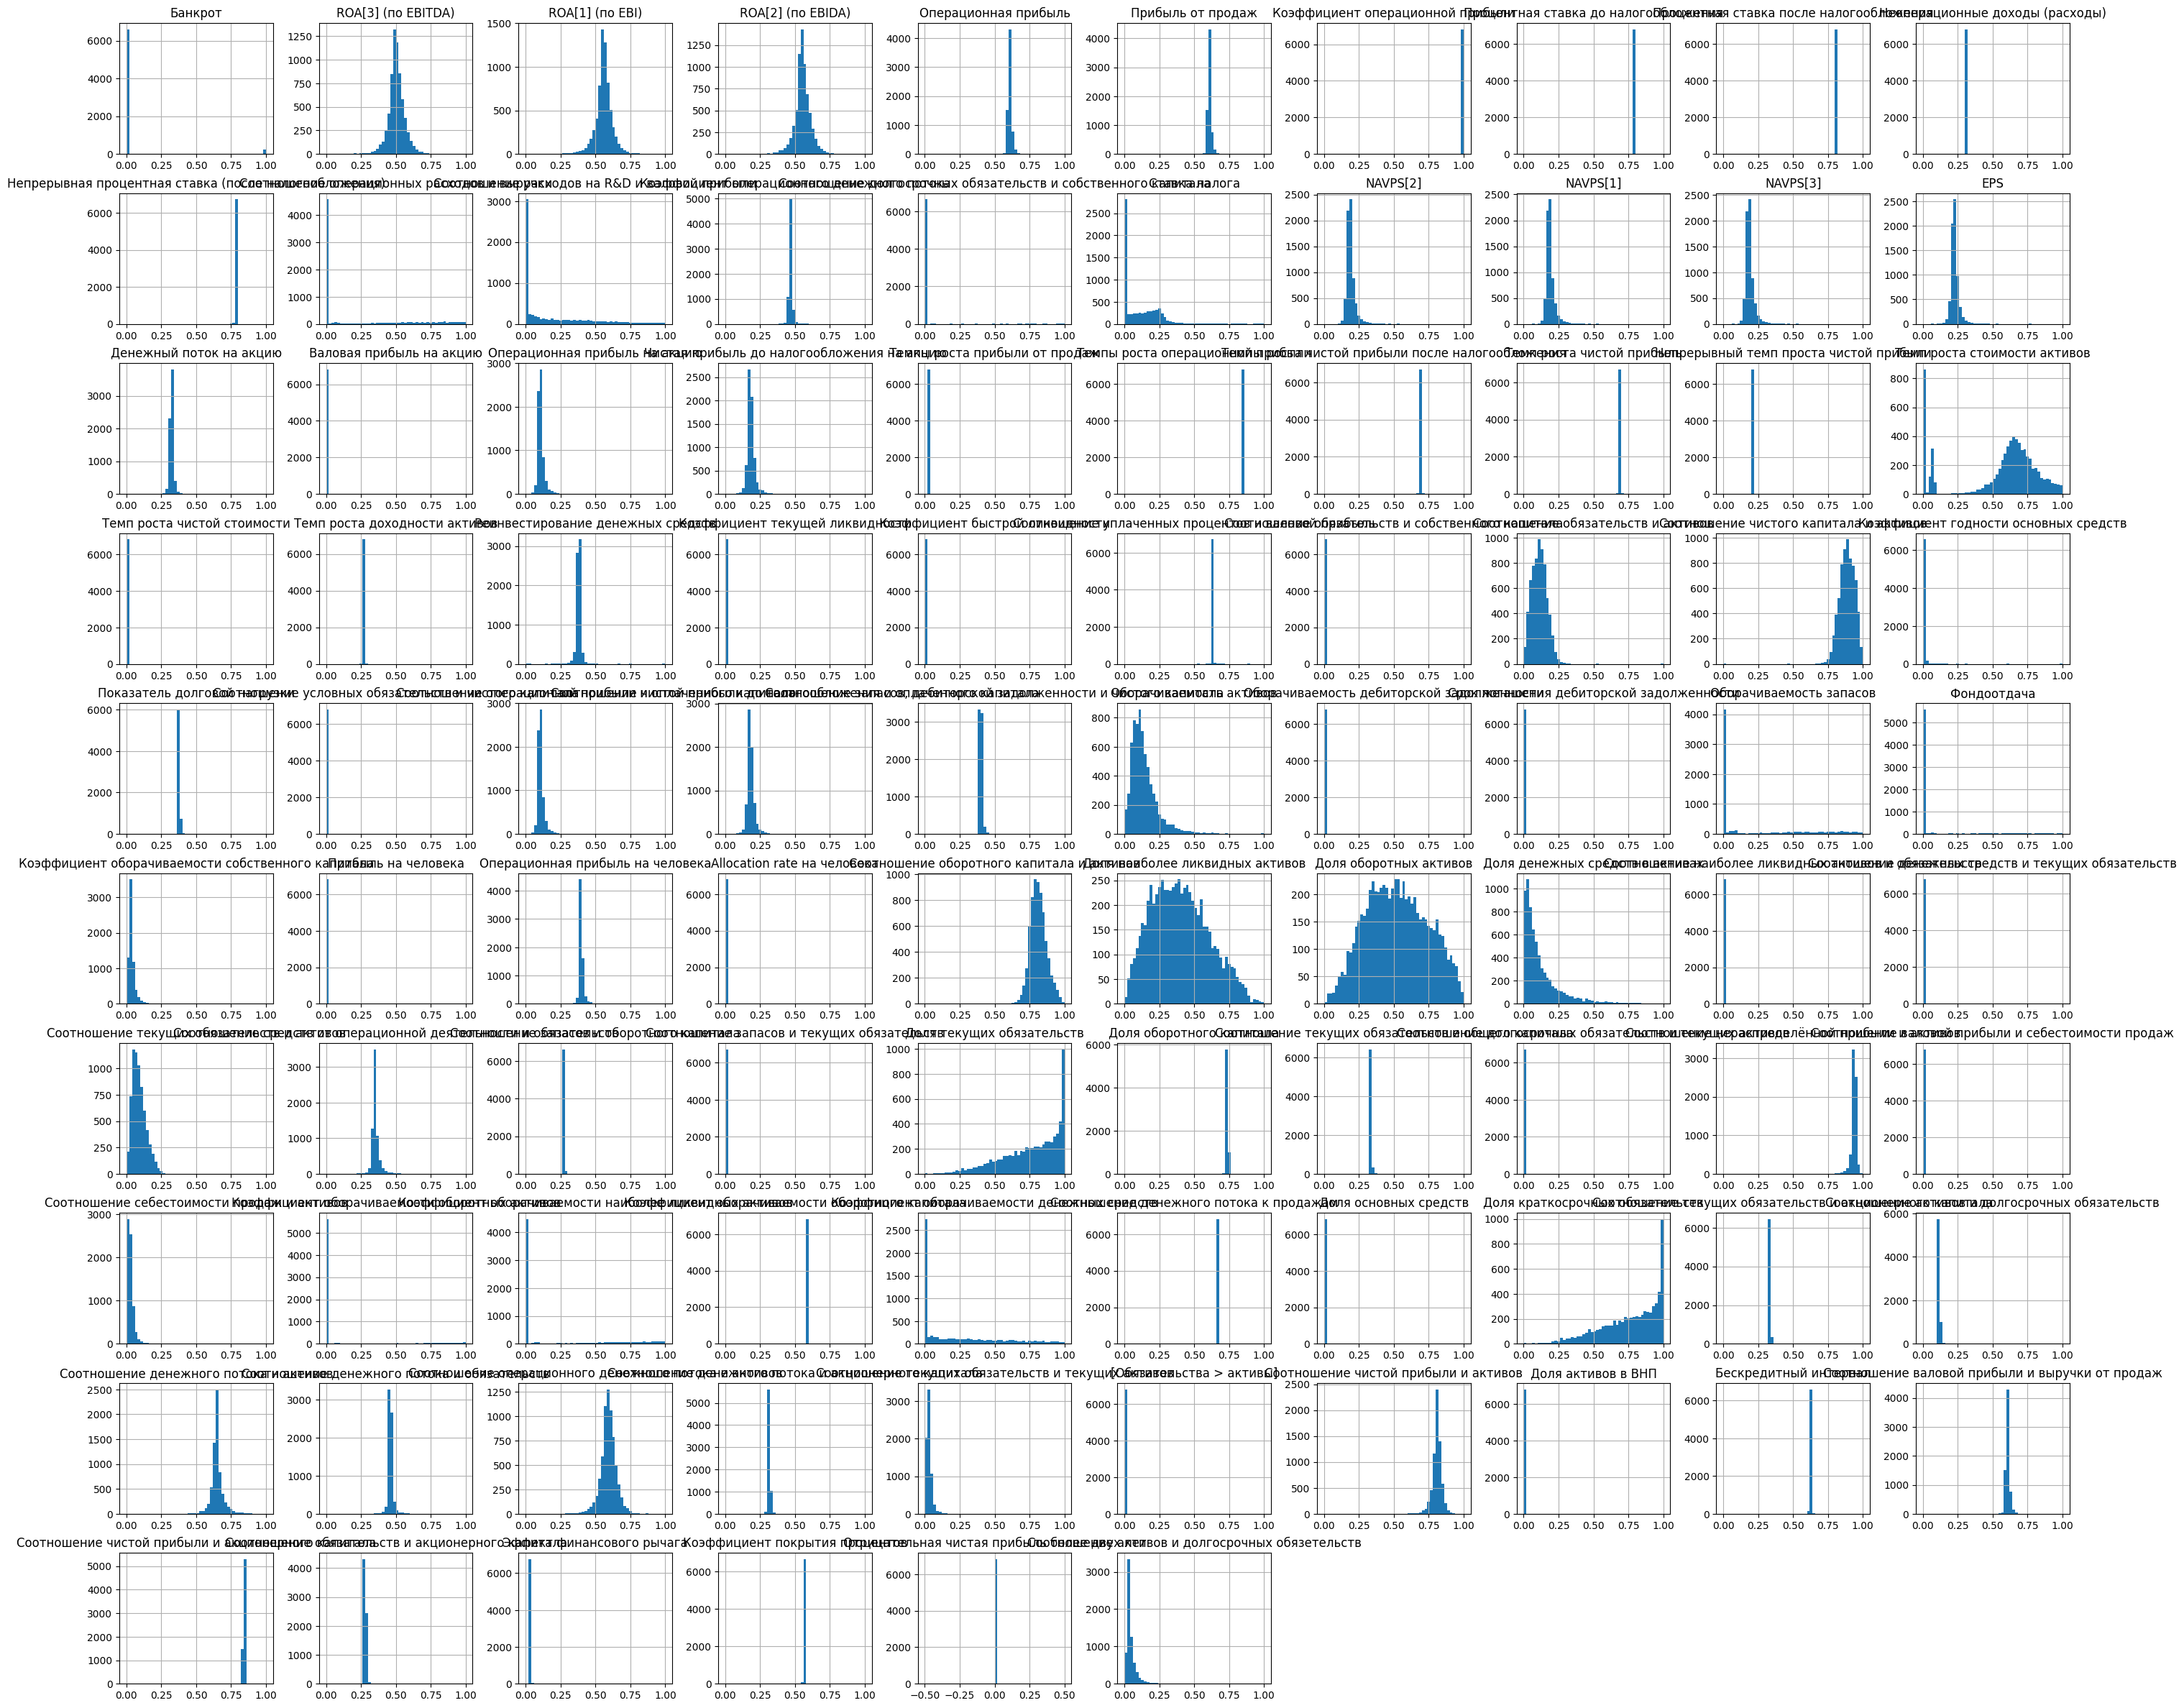

In [ ]:
scaled_df.hist(figsize = (35,30), bins = 50)
plt.show()

Посмотрим на корреляционную матрицу признаков.

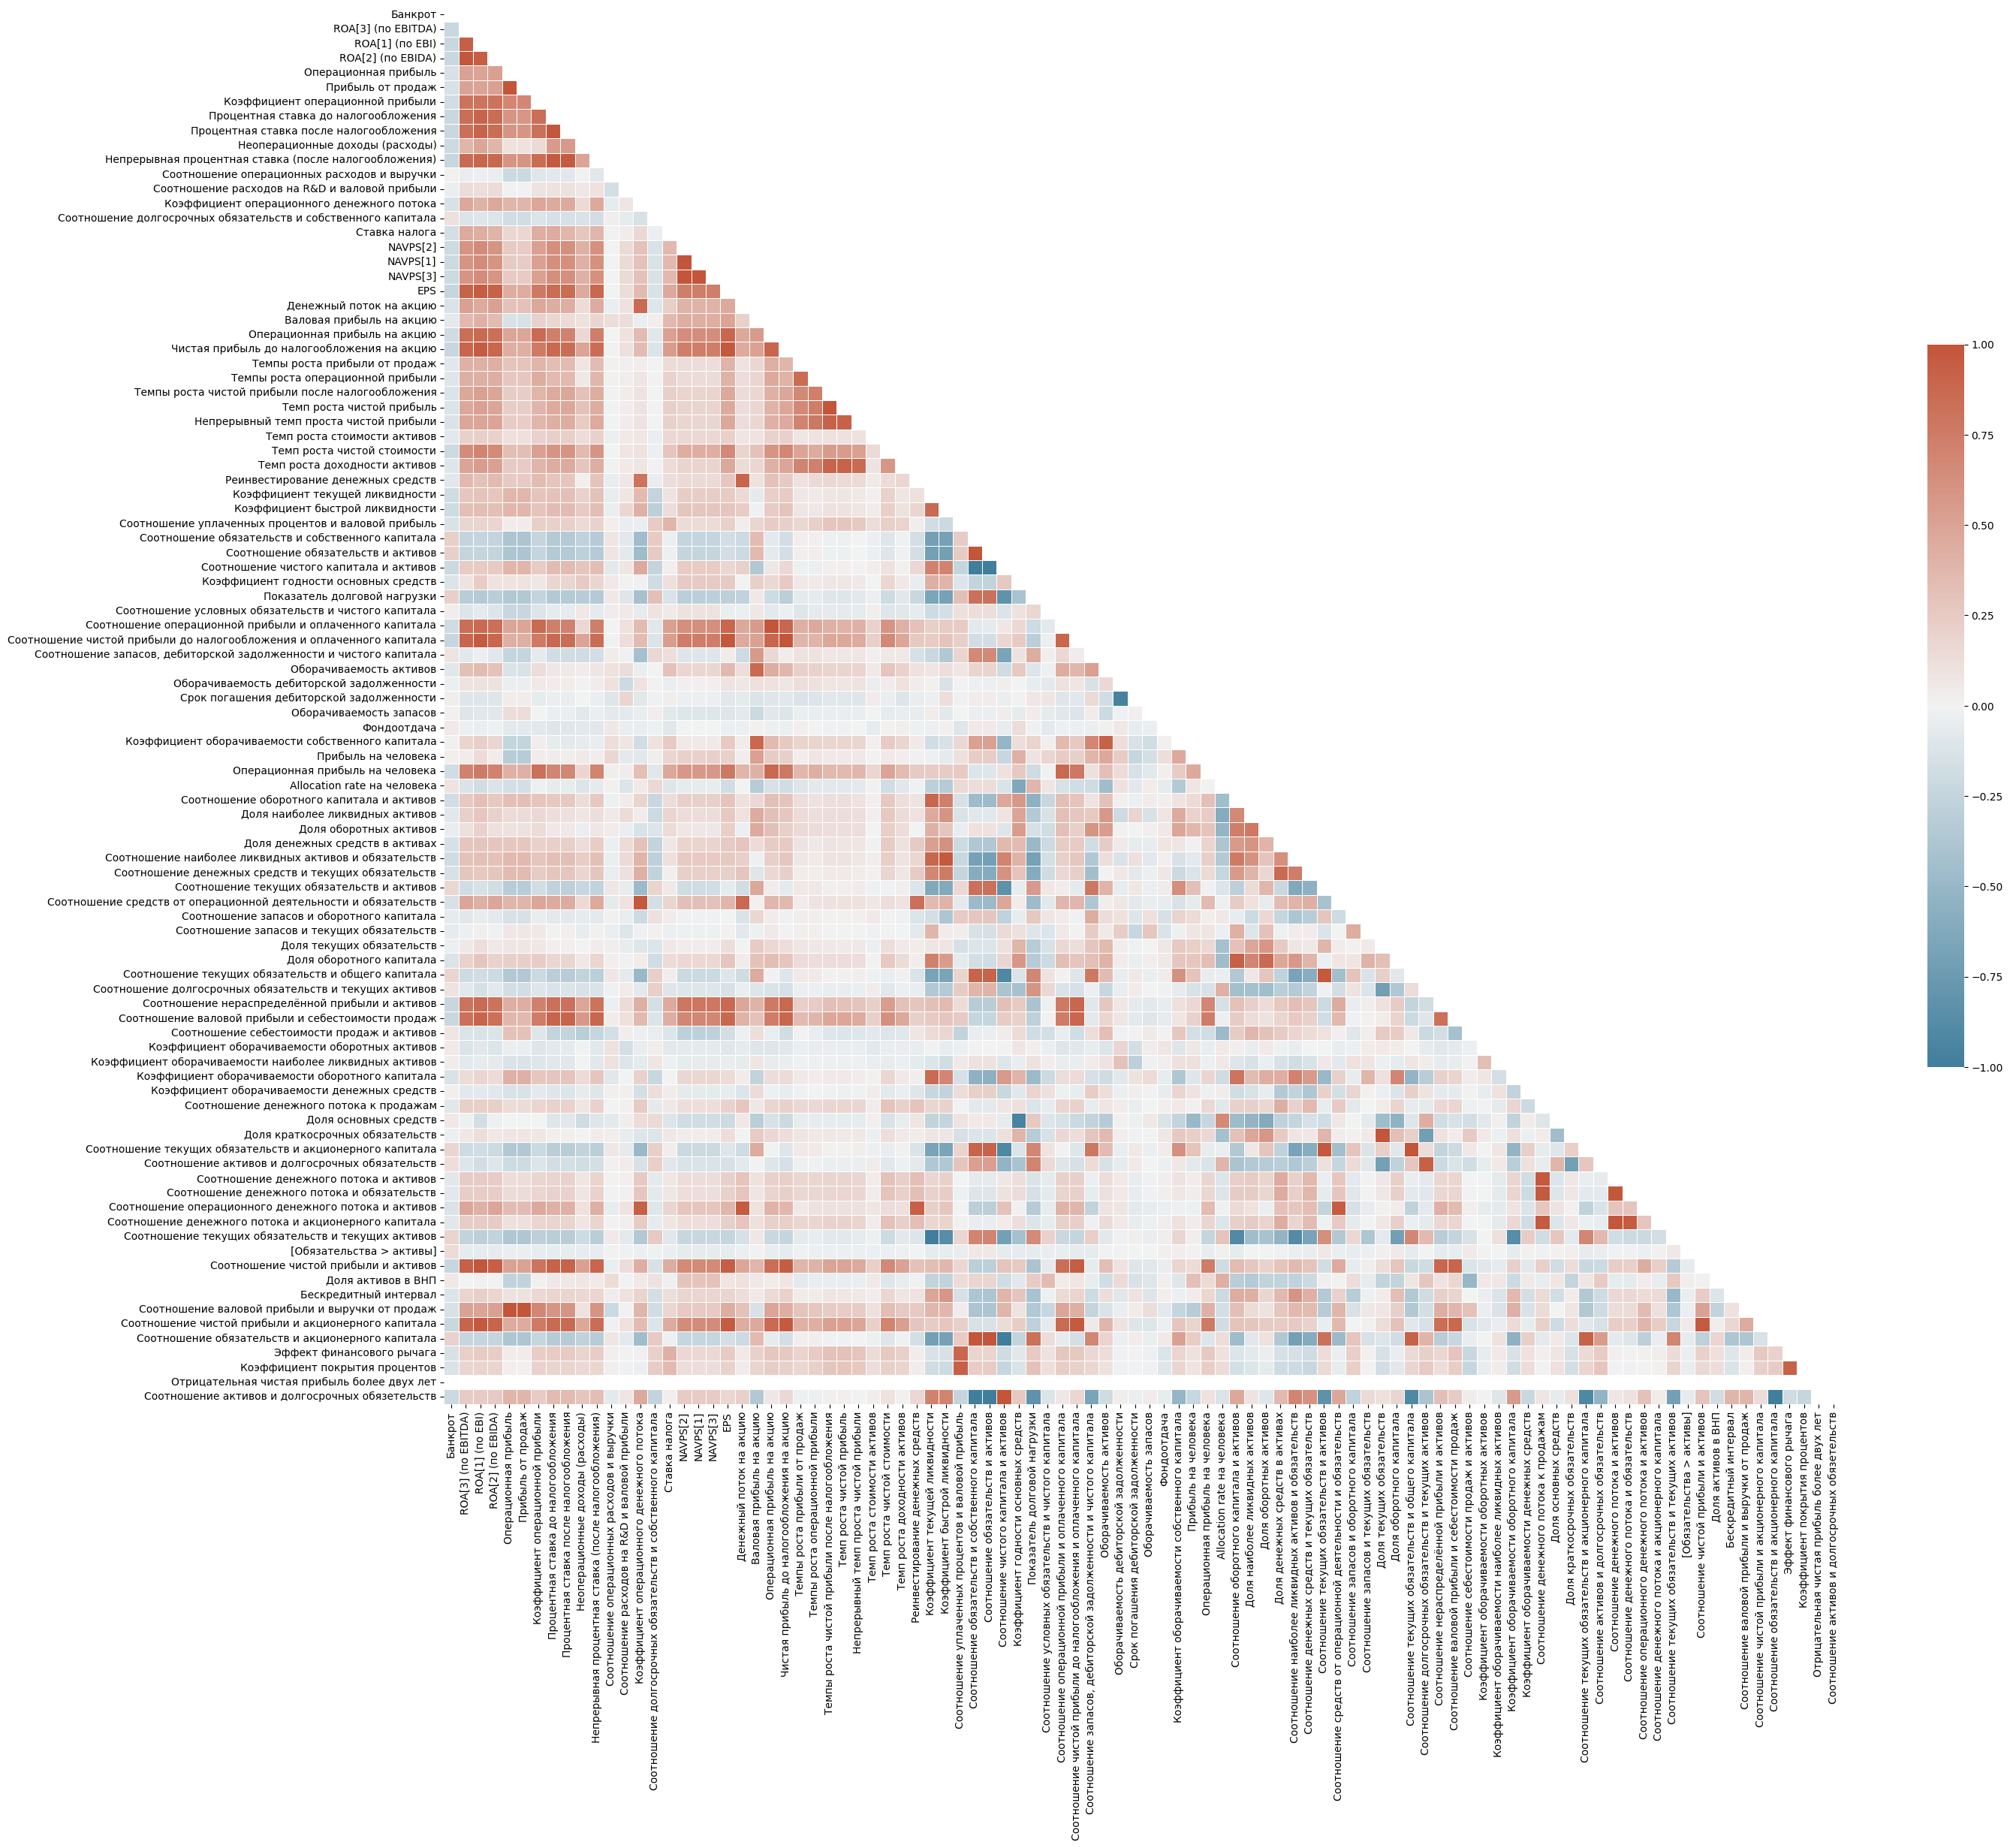

In [ ]:
f, ax = plt.subplots(figsize=(30, 25))
mat = scaled_df.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
for col in scaled_df.columns:
    print(col)

Банкрот
ROA[3] (по EBITDA)
ROA[1] (по EBI)
ROA[2] (по EBIDA)
Операционная прибыль
Прибыль от продаж
Коэффициент операционной прибыли
Процентная ставка до налогообложения
Процентная ставка после налогообложения
Неоперационные доходы (расходы)
Непрерывная процентная ставка (после налогообложения)
Соотношение операционных расходов и выручки
Соотношение расходов на R&D и валовой прибыли
Коэффициент операционного денежного потока
Соотношение долгосрочных обязательств и собственного капитала
Ставка налога
NAVPS[2]
NAVPS[1]
NAVPS[3]
EPS
Денежный поток на акцию
Валовая прибыль на акцию
Операционная прибыль на акцию
Чистая прибыль до налогообложения на акцию
Темпы роста прибыли от продаж
Темпы роста операционной прибыли
Темпы роста чистой прибыли после налогообложения
Темп роста чистой прибыль
Непрерывный темп проста чистой прибыли
Темп роста стоимости активов
Темп роста чистой стоимости
Темп роста доходности активов
Реинвестирование денежных средств
Коэффициент текущей ликвидности
Коэффициент 

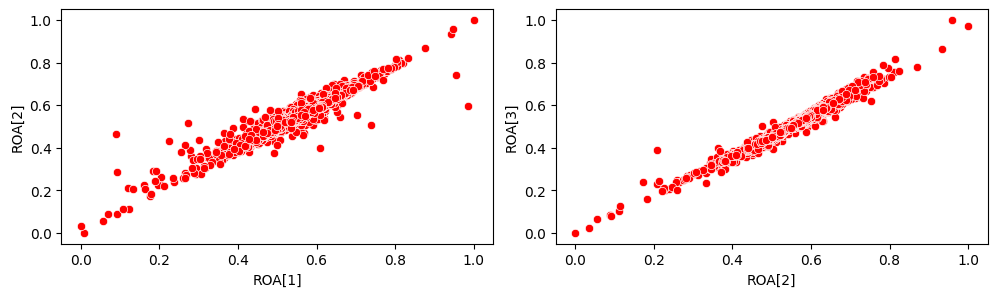

In [ ]:
plt.figure(figsize=(10,3))

#plt.suptitle("Correlation Between Negative Attributes")

plt.subplot(1,2,1)
plt.xlabel("ROA[1]")
plt.ylabel("ROA[2]")
sns.scatterplot(data=scaled_df, x='ROA[1] (по EBI)', y='ROA[2] (по EBIDA)',color = 'red')

plt.subplot(1,2,2)
plt.xlabel("ROA[2]")
plt.ylabel("ROA[3]")
sns.scatterplot(data=scaled_df, x='ROA[2] (по EBIDA)', y='ROA[3] (по EBITDA)',color = 'red')

plt.tight_layout(pad=0.8)

Построим для каждого признака так называемые «ящики с усами» — диаграммы, отражающие значения квартилей распределения случайной величины $\phi$ и «выбросы», то есть те значения данной величины, которые выходят за рамки промежутка $[\mathsf{W}_*(\phi), \, \mathsf{W}^*(\phi)]$, где

*   $\mathsf{Q}_n(\phi)$ есть $n$-й ($n = 1, 2, 3$) квартиль случайной величины $\phi$, то есть $\mathbb{P}(\phi \leqslant \mathsf{Q}_1(\phi)) = n \div 4$;
*   $\mathsf{IQR}(\phi) = \mathsf{Q}_3(\phi) - \mathsf{Q}_1(\phi)$ есть *интерквартильный размах*;
*   $\mathsf{W}^*(\phi) = \mathsf{Q}_3(\phi) + 1.5 \, \mathsf{IQR}(\phi)$ есть верхний «ус»;
*   $\mathsf{W}_*(\phi) = \mathsf{Q}_1(\phi) - 1.5 \, \mathsf{IQR}(\phi)$ есть нижний «ус».

$\mathsf{W}$ от англ. whisker (ус), $\mathsf{IQR}$ от англ. interquartile range.

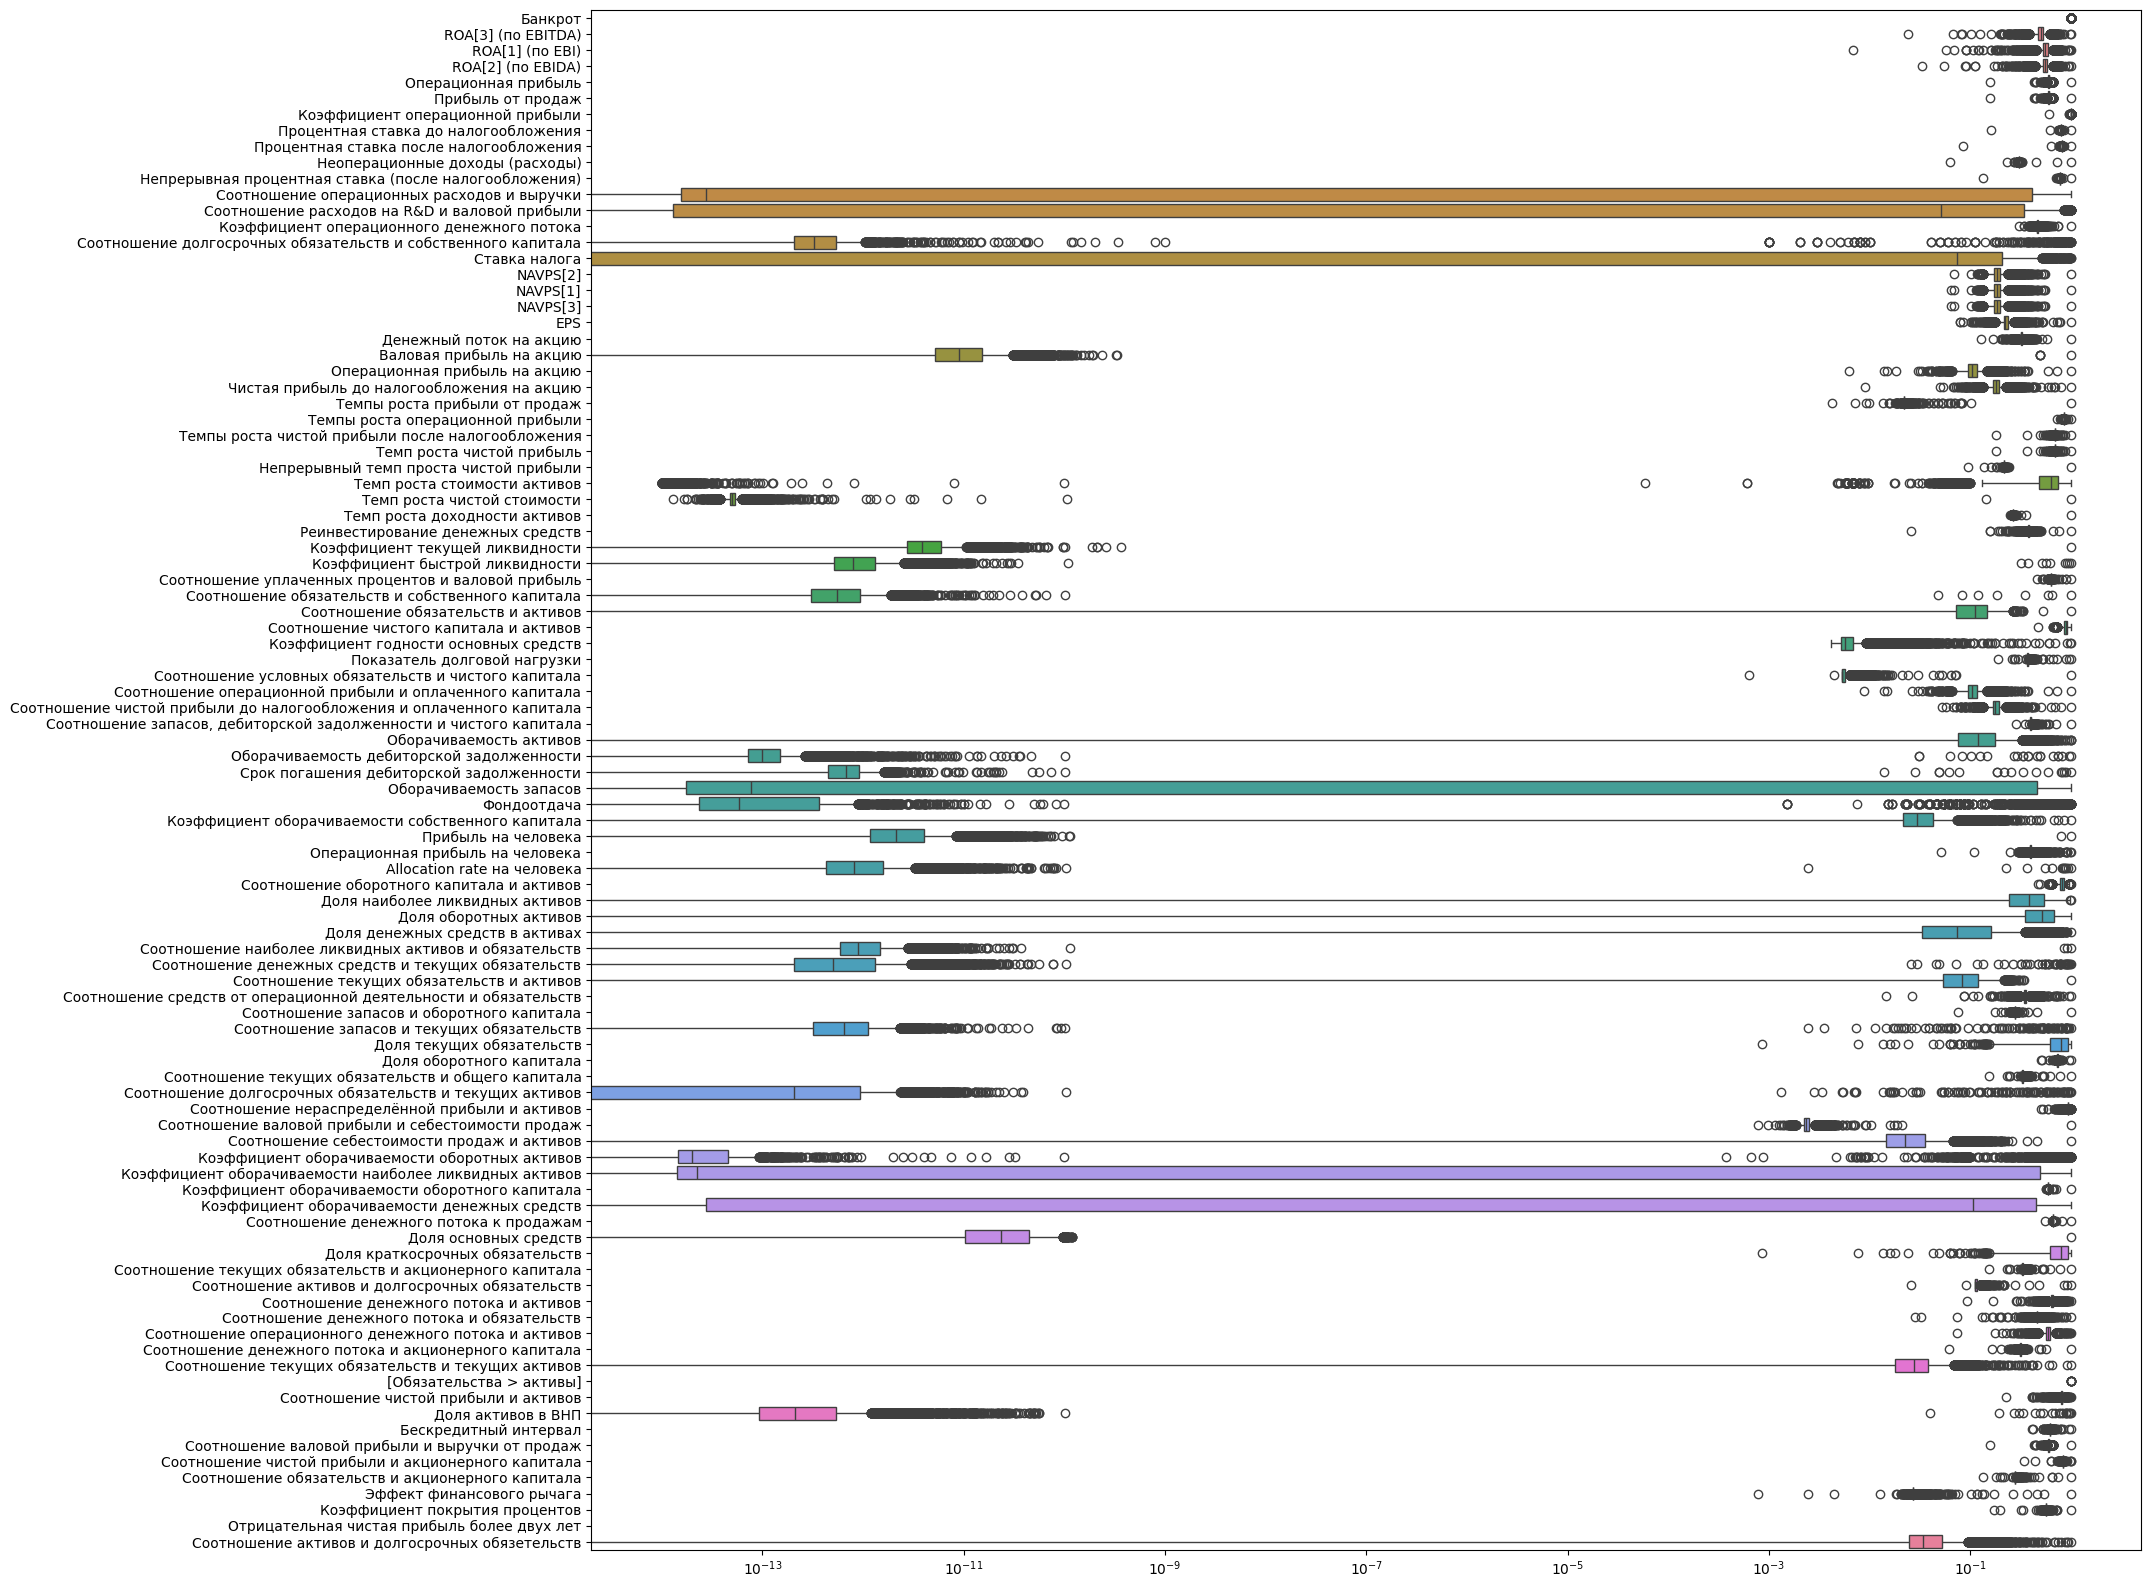

In [ ]:
plt.figure(figsize = (20,20))
ax = sns.boxplot(data = scaled_df, orient = "h")
#ax.set_title('«Ящики с усами» выделенных признаков', fontsize = 18)
ax.set(xscale = "log")
plt.show()

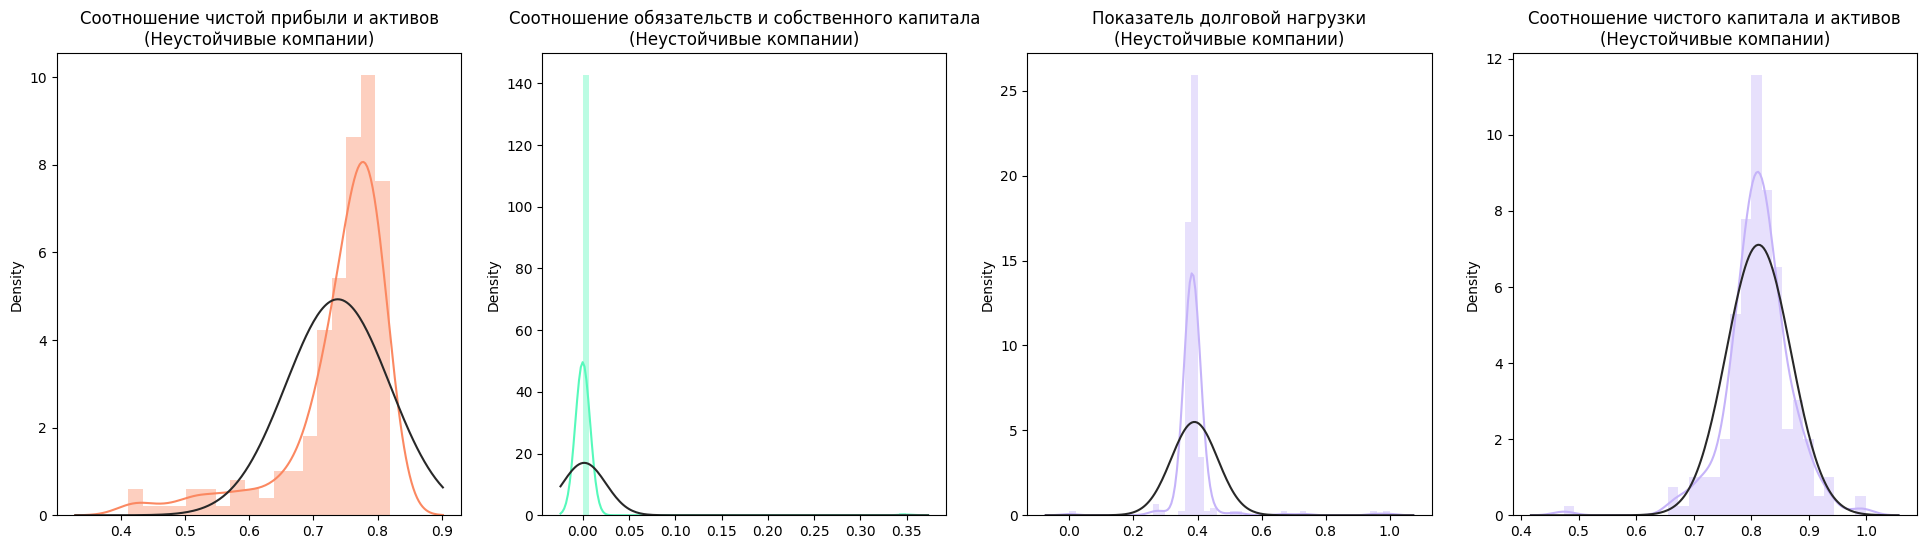

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = scaled_df['Соотношение чистой прибыли и активов'].loc[df['Банкрот'] == 1].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Соотношение чистой прибыли и активов\n(Неустойчивые компании)', fontsize=12)

tot_debt_net = scaled_df['Соотношение обязательств и собственного капитала'].loc[df['Банкрот'] == 1].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Соотношение обязательств и собственного капитала\n(Неустойчивые компании)', fontsize=12)


debt_ratio = scaled_df['Показатель долговой нагрузки'].loc[df['Банкрот'] == 1].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Показатель долговой нагрузки\n(Неустойчивые компании)', fontsize=12)

net_worth_assets = scaled_df['Соотношение чистого капитала и активов'].loc[df['Банкрот'] == 1].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('Соотношение чистого капитала и активов\n(Неустойчивые компании)', fontsize=12)

plt.show()

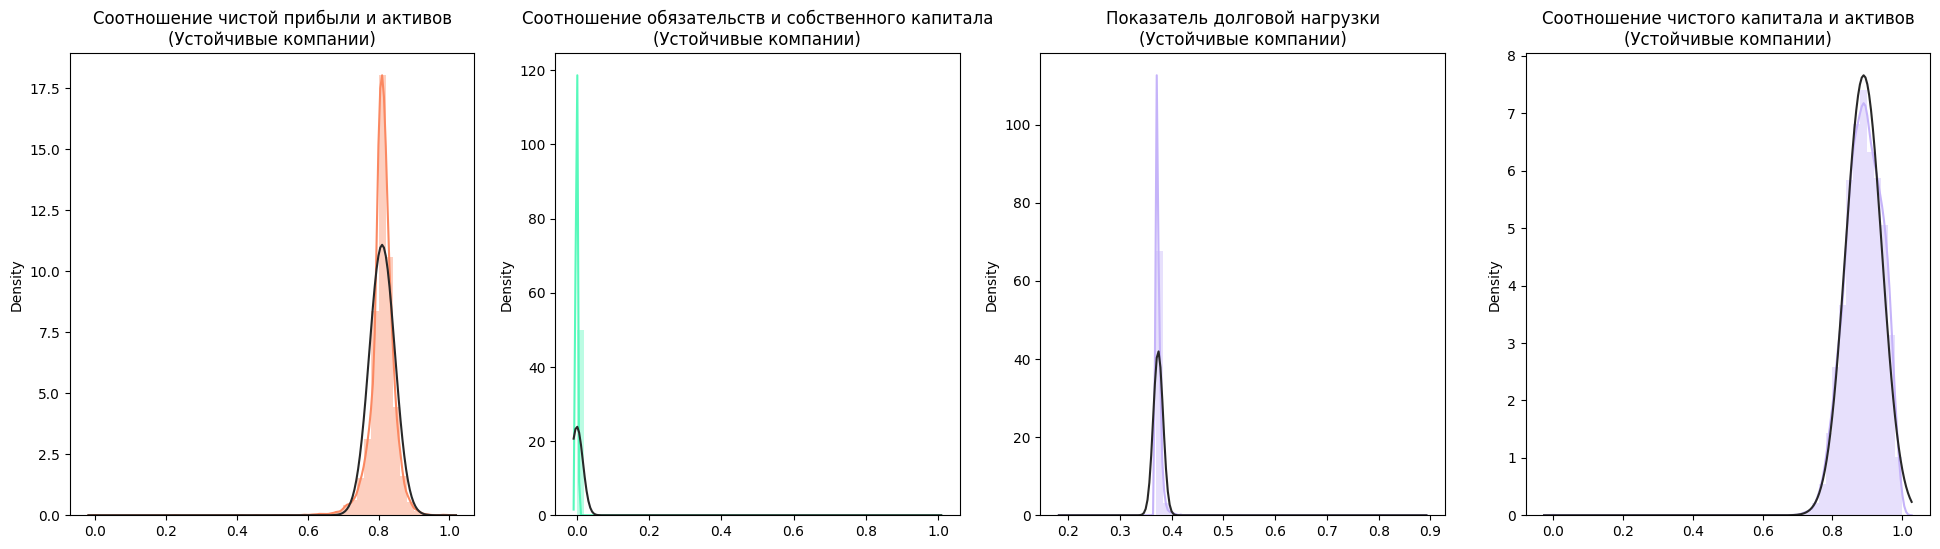

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = scaled_df['Соотношение чистой прибыли и активов'].loc[df['Банкрот'] == 0].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Соотношение чистой прибыли и активов\n(Устойчивые компании)', fontsize=12)

tot_debt_net = scaled_df['Соотношение обязательств и собственного капитала'].loc[df['Банкрот'] == 0].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Соотношение обязательств и собственного капитала\n(Устойчивые компании)', fontsize=12)


debt_ratio = scaled_df['Показатель долговой нагрузки'].loc[df['Банкрот'] == 0].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Показатель долговой нагрузки\n(Устойчивые компании)', fontsize=12)

net_worth_assets = scaled_df['Соотношение чистого капитала и активов'].loc[df['Банкрот'] == 0].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('Соотношение чистого капитала и активов\n(Устойчивые компании)', fontsize=12)

plt.show()

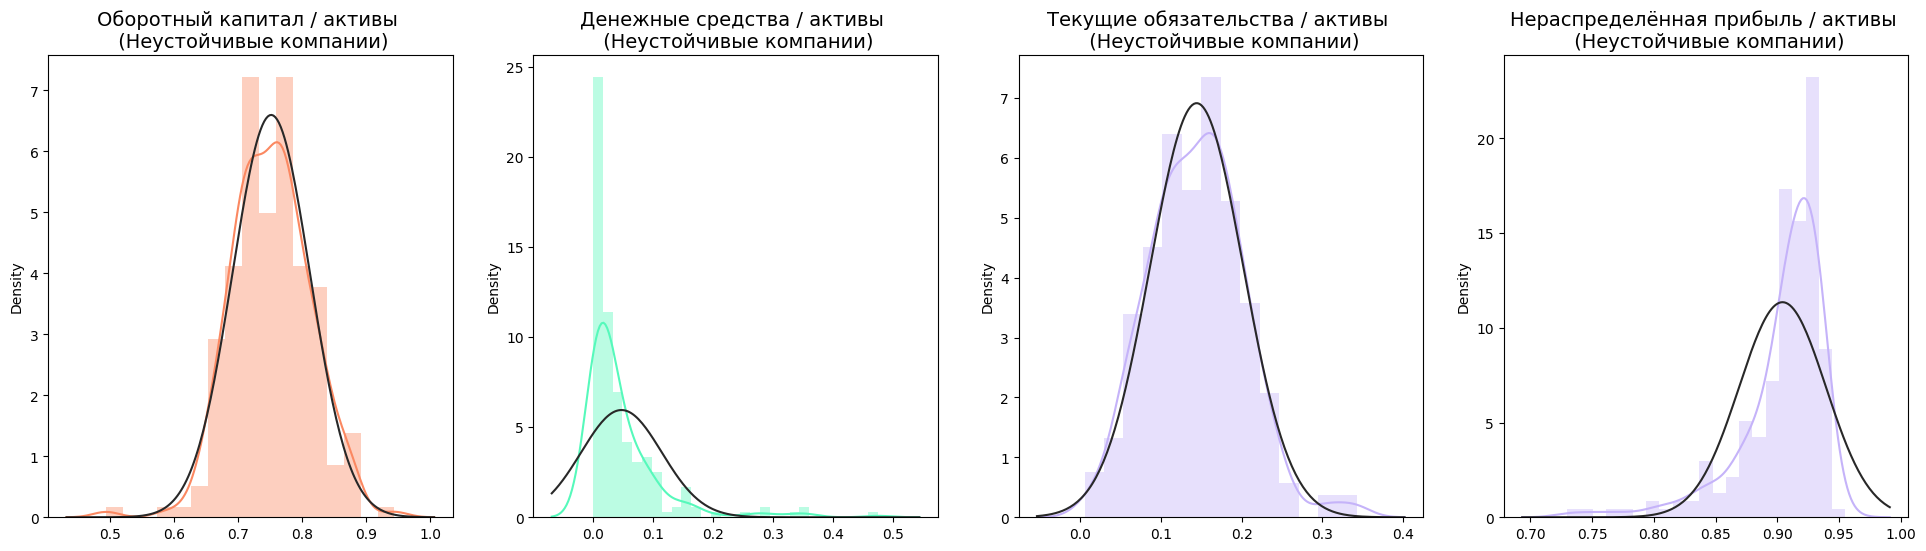

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

working_cap = df[' Working Capital to Total Assets'].loc[df['Bankrupt?'] == 1].values
sns.distplot(working_cap,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Оборотный капитал / активы \n (Неустойчивые компании)', fontsize=14)

cash_tot_assets = df[' Cash/Total Assets'].loc[df['Bankrupt?'] == 1].values
sns.distplot(cash_tot_assets ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Денежные средства / активы \n (Неустойчивые компании)', fontsize=14)


asset_liab = df[' Current Liability to Assets'].loc[df['Bankrupt?'] == 1].values
sns.distplot(asset_liab,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Текущие обязательства / активы \n (Неустойчивые компании)', fontsize=14)

operating_funds = df[' Retained Earnings to Total Assets'].loc[df['Bankrupt?'] == 1].values
sns.distplot(operating_funds,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('Нераспределённая прибыль / активы \n (Неустойчивые компании)', fontsize=14)

plt.show()

# **Часть III. Предварительная обработка данных**

Усечём выборку.

In [ ]:
def outliers_removal(feature, feature_name, dataset):

    # Identify 25th & 75th quartiles

    Q1, Q3 = np.percentile(feature, 25), np.percentile(feature, 75)
    print(f'Первый квартиль: {Q1} | Третий квартиль: {Q3}')
    IQR = Q3 - Q1
    print(f'Интерквартильный размах: {IQR}')

    lower_whisker, upper_whisker = Q1 - 1.5 *  IQR, Q3 + 1.5 * IQR
    print(f'Нижняя граница уса признака «{feature_name}»: {lower_whisker}')
    print(f'Верхняя граница уса признака «{feature_name}»: {upper_whisker}')

    outliers = [x for x in feature if x < lower_whisker or x > upper_whisker]
    print(f'Количество выбросов по признаку «{feature_name}»: {len(outliers)}')
    #if show_outliers
    #print(f'Выбросы по признаку {feature_name}: {outliers}')

    dataset = dataset.drop(dataset[(dataset[feature_name] > upper_whisker) | \
     (dataset[feature_name] < lower_whisker)].index)
    print('—' * 100)

    return dataset

for col in scaled_df:
    trunc_df = outliers_removal(scaled_df[col], str(col), scaled_df)

Первый квартиль: 0.0 | Третий квартиль: 0.0
Интерквартильный размах: 0.0
Нижняя граница уса признака «Банкрот»: 0.0
Верхняя граница уса признака «Банкрот»: 0.0
Количество выбросов по признаку «Банкрот»: 220
————————————————————————————————————————————————————————————————————————————————————————————————————
Первый квартиль: 0.476527080388047 | Третий квартиль: 0.535562813825379
Интерквартильный размах: 0.05903573343733198
Нижняя граница уса признака «ROA[3] (по EBITDA)»: 0.38797348023204903
Верхняя граница уса признака «ROA[3] (по EBITDA)»: 0.624116413981377
Количество выбросов по признаку «ROA[3] (по EBITDA)»: 391
————————————————————————————————————————————————————————————————————————————————————————————————————
Первый квартиль: 0.53554295682512 | Третий квартиль: 0.58915721761884
Интерквартильный размах: 0.05361426079372
Нижняя граница уса признака «ROA[1] (по EBI)»: 0.45512156563454
Верхняя граница уса признака «ROA[1] (по EBI)»: 0.66957860880942
Количество выбросов по признаку «ROA

Заметим (см. следующую ячейку), что в нашей таблице в столбце `Net Income Flag` все значения равны 1. Получается, указанный признак никак не поможет нашей модели в обнаружении искомых закономерностей: можно сказать, что его информационная энтропия равна нулю. Ввиду этого данный столбец мы удалим.

In [ ]:
scaled_df['Отрицательная чистая прибыль более двух лет'].value_counts(0)

Отрицательная чистая прибыль более двух лет
0.0    6819
Name: count, dtype: int64

Определим функцию для предварительной обработки исходного датафрейма.

In [ ]:
def preprocess(df):
    df = df.copy()

    # Редукция признака, тождественно равного единице
    df = df.drop('Отрицательная чистая прибыль более двух лет', axis=1)

    # Разделение датасета на матрицу объект-признак и столбец целевой перменной
    y = df['Банкрот']
    X = df.drop('Банкрот', axis=1)

    # Разделение выборки обучающую и тестовую её части
    X_train, X_test, y_train, y_test =\
    train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

    # Стандартизированная нормировка (центрирование)
    #scaler = StandardScaler()
    #scaler.fit(X_train)
    #X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index,\
    #                       columns=X_train.columns)
    #X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index,\
    #                      columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess(trunc_df)

# **Часть IV. Обучение и оценка качества моделей**

In [ ]:
X = trunc_df.drop(['Банкрот', 'Отрицательная чистая прибыль более двух лет'], axis=1)

Качество обучения логистической регрессии (в процентах)

Accuracy: 	 96.54
Precision: 	 95.43
Recall: 	 96.54
F1_score: 	 95.29
ROC AUC: 	 54.37

Гистограмма распрделения коэффициентов модели


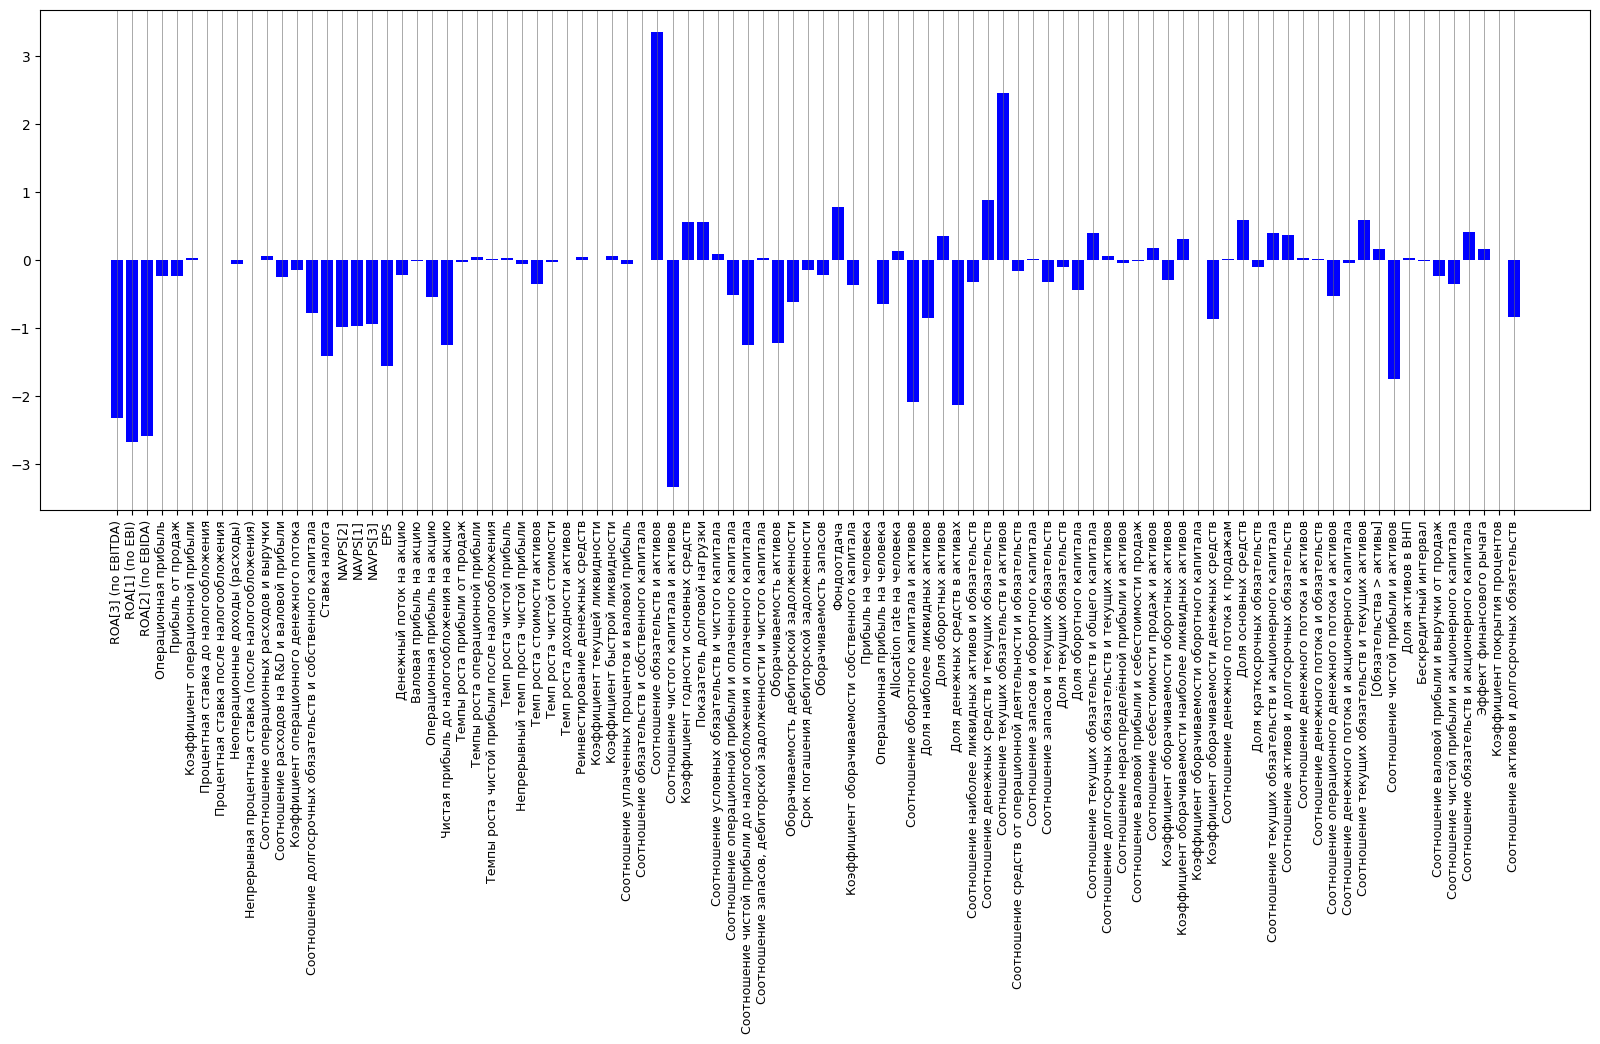

In [ ]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)

print('Качество обучения логистической регрессии (в процентах)\n')
print(f"Accuracy: \t {100 * accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: \t {100 * precision_score(y_test, y_pred,average='weighted'):.2f}")
print(f"Recall: \t {100 * recall_score(y_test, y_pred,average='weighted'):.2f}")
print(f"F1_score: \t {100 * f1_score(y_test, y_pred,average='weighted'):.2f}")
print(f"ROC AUC: \t {100 * roc_auc_score(y_test, y_pred):.2f}")

print('\nГистограмма распрделения коэффициентов модели')
plt.figure(figsize=(20, 6.5))
plt.bar(list(X), model_LR.coef_[0], color = 'blue')
plt.xticks(rotation=90, fontsize=9)
plt.grid(True, axis='x', color = "dimgray", linewidth = "0.4")
plt.show()

In [ ]:
model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train, y_train)
y_pred = model_KNN.predict(X_test)

print('Качество обучения логистической регрессии (в процентах)\n')
print(f"Accuracy: \t {100 * accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: \t {100 * precision_score(y_test, y_pred,average='weighted'):.2f}")
print(f"Recall: \t {100 * recall_score(y_test, y_pred,average='weighted'):.2f}")
print(f"F1_score: \t {100 * f1_score(y_test, y_pred,average='weighted'):.2f}")
print(f"ROC AUC: \t {100 * roc_auc_score(y_test, y_pred):.2f}")

Качество обучения логистической регрессии (в процентах)

Accuracy: 	 96.28
Precision: 	 93.76
Recall: 	 96.28
F1_score: 	 94.71
ROC AUC: 	 50.64


In [ ]:
model_DT = DecisionTreeClassifier()
model_DT.fit(X_train, y_train)
y_pred = model_DT.predict(X_test)

print('Качество обучения логистической регрессии (в процентах)\n')
print(f"Accuracy: \t {100 * accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: \t {100 * precision_score(y_test, y_pred,average='weighted'):.2f}")
print(f"Recall: \t {100 * recall_score(y_test, y_pred,average='weighted'):.2f}")
print(f"F1_score: \t {100 * f1_score(y_test, y_pred,average='weighted'):.2f}")
print(f"ROC AUC: \t {100 * roc_auc_score(y_test, y_pred):.2f}")

Качество обучения логистической регрессии (в процентах)

Accuracy: 	 94.95
Precision: 	 95.20
Recall: 	 94.95
F1_score: 	 95.07
ROC AUC: 	 65.76


In [ ]:
model_RF = RandomForestClassifier()
model_RF.fit(X_train, y_train)
y_pred = model_RF.predict(X_test)

print('Качество обучения логистической регрессии (в процентах)\n')
print(f"Accuracy: \t {100 * accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: \t {100 * precision_score(y_test, y_pred,average='weighted'):.2f}")
print(f"Recall: \t {100 * recall_score(y_test, y_pred,average='weighted'):.2f}")
print(f"F1_score: \t {100 * f1_score(y_test, y_pred,average='weighted'):.2f}")
print(f"ROC AUC: \t {100 * roc_auc_score(y_test, y_pred):.2f}")

Качество обучения логистической регрессии (в процентах)

Accuracy: 	 96.65
Precision: 	 95.72
Recall: 	 96.65
F1_score: 	 95.64
ROC AUC: 	 57.30


In [ ]:
model_LinSVC = LinearSVC()
model_LinSVC.fit(X_train, y_train)
y_pred = model_LinSVC.predict(X_test)

print('Качество обучения логистической регрессии (в процентах)\n')
print(f"Accuracy: \t {100 * accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: \t {100 * precision_score(y_test, y_pred,average='weighted'):.2f}")
print(f"Recall: \t {100 * recall_score(y_test, y_pred,average='weighted'):.2f}")
print(f"F1_score: \t {100 * f1_score(y_test, y_pred,average='weighted'):.2f}")
print(f"ROC AUC: \t {100 * roc_auc_score(y_test, y_pred):.2f}")

Качество обучения логистической регрессии (в процентах)

Accuracy: 	 96.60
Precision: 	 95.61
Recall: 	 96.60
F1_score: 	 95.40
ROC AUC: 	 55.11


In [ ]:
model_SVC = SVC()
model_SVC.fit(X_train, y_train)
y_pred = model_SVC.predict(X_test)

print('Качество обучения логистической регрессии (в процентах)\n')
print(f"Accuracy: \t {100 * accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: \t {100 * precision_score(y_test, y_pred,average='weighted'):.2f}")
print(f"Recall: \t {100 * recall_score(y_test, y_pred,average='weighted'):.2f}")
print(f"F1_score: \t {100 * f1_score(y_test, y_pred,average='weighted'):.2f}")
print(f"ROC AUC: \t {100 * roc_auc_score(y_test, y_pred):.2f}")

Качество обучения логистической регрессии (в процентах)

Accuracy: 	 96.44
Precision: 	 93.00
Recall: 	 96.44
F1_score: 	 94.69
ROC AUC: 	 50.00


In [ ]:
model_NN = MLPClassifier()
model_NN.fit(X_train, y_train)
y_pred = model_NN.predict(X_test)

print('Качество обучения логистической регрессии (в процентах)\n')
print(f"Accuracy: \t {100 * accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: \t {100 * precision_score(y_test, y_pred,average='weighted'):.2f}")
print(f"Recall: \t {100 * recall_score(y_test, y_pred,average='weighted'):.2f}")
print(f"F1_score: \t {100 * f1_score(y_test, y_pred,average='weighted'):.2f}")
print(f"ROC AUC: \t {100 * roc_auc_score(y_test, y_pred):.2f}")

Качество обучения логистической регрессии (в процентах)

Accuracy: 	 96.49
Precision: 	 95.48
Recall: 	 96.49
F1_score: 	 95.71
ROC AUC: 	 59.37


In [ ]:
model_GB = GradientBoostingClassifier()
model_GB.fit(X_train, y_train)
y_pred = model_GB.predict(X_test)

print('Качество обучения логистической регрессии (в процентах)\n')
print(f"Accuracy: \t {100 * accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: \t {100 * precision_score(y_test, y_pred,average='weighted'):.2f}")
print(f"Recall: \t {100 * recall_score(y_test, y_pred,average='weighted'):.2f}")
print(f"F1_score: \t {100 * f1_score(y_test, y_pred,average='weighted'):.2f}")
print(f"ROC AUC: \t {100 * roc_auc_score(y_test, y_pred):.2f}")

Качество обучения логистической регрессии (в процентах)

Accuracy: 	 96.28
Precision: 	 95.46
Recall: 	 96.28
F1_score: 	 95.76
ROC AUC: 	 62.14


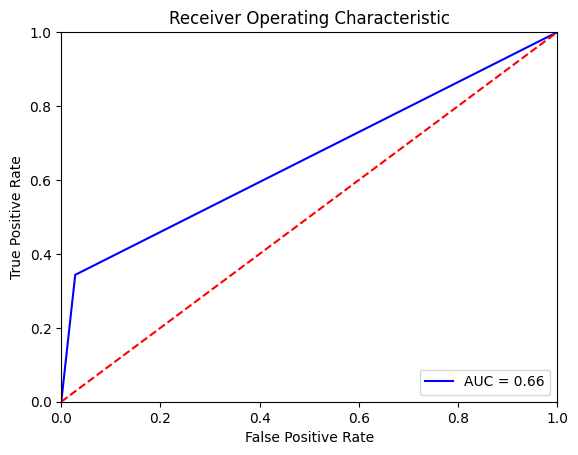

In [ ]:
from sklearn.metrics import auc, roc_curve

y_pred_DT = model_DT.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_DT)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()